# Preamble

In [252]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox

plt.style.use('seaborn-v0_8-notebook')
%config InlineBackend.figure_format = 'retina' 

In [253]:
data = 'data/car_price.csv'

cars = pd.read_csv(data)

cars.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


# Cleaning Data

## Extracting Manufacturer

In [254]:
cars['mfr'] = cars['car_name'].apply(lambda x: x.split()[0])

## Converting Rupees to USD

In [255]:
cars['price'] = cars['car_prices_in_rupee'].apply(lambda x: float(re.sub(',', '.', x.split()[0])) * 100000 * .012)

## Converting Odometers to Miles

In [256]:
cars['miles'] = cars['kms_driven'].apply(lambda x: float(re.sub(',', '', x.split()[0])) * 0.621371)

## Converting Cubic Centimeters to Liters

In [257]:
cars['engine'] = cars['engine'].apply(lambda x: float(x.split()[0]) / 1000)

## Extracting `Seats` as Numeric

In [258]:
cars['Seats'] = cars['Seats'].apply(lambda x: float(x.split()[0]))

## Converting `ownership` to binary classifier

In [259]:
tmp = cars['ownership'].apply(lambda x: float(re.findall('\d+', x)[0]))

cars['new'] = [1 if x <= 1 else 0 for x in tmp]

In [260]:
cars.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,mfr,price,miles,new
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1.956,5.0,Jeep,12036.0,53578.335846,1
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1.330,5.0,Renault,15396.0,8231.923008,1
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2.494,5.0,Toyota,19680.0,37495.390253,1
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1.199,5.0,Honda,9324.0,16588.120216,1
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1.199,5.0,Volkswagen,6180.0,43131.846594,1


# Checking VIF

In [261]:
y, X = dmatrices('price ~ fuel_type + transmission + manufacture + engine + C(Seats) + mfr + miles + C(new)', 
                 data=cars, 
                 return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                features
0   437608.962925               Intercept
1       18.501757     fuel_type[T.Diesel]
2        1.234138   fuel_type[T.Electric]
3        1.372532        fuel_type[T.Lpg]
4       18.178456     fuel_type[T.Petrol]
5        2.033542  transmission[T.Manual]
6       18.494864         C(Seats)[T.4.0]
7      143.903147         C(Seats)[T.5.0]
8       13.189746         C(Seats)[T.6.0]
9      113.833819         C(Seats)[T.7.0]
10      11.812934         C(Seats)[T.8.0]
11       1.982338              mfr[T.BMW]
12       1.007654          mfr[T.Bentley]
13       1.626921        mfr[T.Chevrolet]
14       1.208211           mfr[T.Datsun]
15       1.134587             mfr[T.Fiat]
16       1.009840            mfr[T.Force]
17       2.188876             mfr[T.Ford]
18       4.352817            mfr[T.Honda]
19       7.284680          mfr[T.Hyundai]
20       1.029061            mfr[T.Isuzu]
21       1.184530           mfr[T.Jaguar]
22       1.342253             mfr[

There appears to be some serious multicollinearity in `Seats`, `fuel_type`, and some potential multicollinearity in `mfr`. Thus we drop `Seats`, `fuel_type` and `mfr` to minimize this risk.

In [262]:
model = smf.ols('price ~ transmission + manufacture + engine + miles + C(new)', 
                 data=cars).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     262.1
Date:                Sat, 07 Oct 2023   Prob (F-statistic):          4.96e-252
Time:                        17:22:42   Log-Likelihood:                -61852.
No. Observations:                5512   AIC:                         1.237e+05
Df Residuals:                    5506   BIC:                         1.238e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6.642e+05   1.53e+05      4.329      0.000    3.63e+05    9.65e+05
transmission[T.Manual] -1.802e+04    572.643    -31.467      0.000   -1.91e+04   -1.69e+04
C(new)[T.1]             1071.6606    573.440      1.869      0.062     -52.509    2195.830
manufacture             -316.0504     76.091     -4.154      0.000    -465.220    -166.881
engine                  1766.1347    427.508      4.131      0.000     928.051    2604.219
miles                     -0.0914      0.011     -8.466      0.000      -0.113      -0.070
==============================================================================
Omnibus:                     3561.600   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40219.692
Skew:                           3.012   Prob(JB):                         0.00
Kurtosis:                      14.782   Cond. No.                     2.97e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Checking Influential Points

In [263]:
# threshold externally studentized residuals
infl = model.get_influence()
n = len(cars)
p = 5

seuil_stud = stats.t.ppf(0.975,df=n-p-1)

# detection - absolute value > threshold
reg_studs = infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud

df_esr = pd.DataFrame({'externally studentized residuals': reg_studs[atyp_stud],
              'residuals': model.resid[atyp_stud]})

df_esr

,externally studentized residuals,residuals
164,2.072841,37462.940598
205,3.044453,54997.666307
227,3.140674,56731.367914
238,6.124324,110335.384488
243,3.095133,55862.656586
...,...,...
5479,2.816668,50888.171150
5481,2.063488,37296.882497
5490,2.154455,38936.858863
5497,2.096503,37891.050753


In [264]:
inflsum = infl.summary_frame()
reg_cook = inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n

c_indices = cars.index[atyp_cook]
c_vals = reg_cook[atyp_cook]

df_cook = pd.DataFrame({"Cook's Distances": reg_cook[atyp_cook]})

df_cook.sort_values(by = "Cook's Distances", ascending = False)

,Cook's Distances
4690,0.029847
3365,0.018417
3076,0.016940
1734,0.014521
1662,0.013658
...,...
4654,0.000746
3042,0.000745
1079,0.000742
871,0.000730


In [265]:
bad = list(set(df_esr.index).intersection(set(df_cook.index)))

len(bad)

258

We find ~258 points to be influential by our external residuals threshold and Cook's distance threshold.

In [266]:
cars_small = cars.drop(bad, errors = 'ignore')

We drop the according influential points and fit the same model so we can compare future tests in both cases.

In [267]:
model_small = smf.ols('price ~ transmission + manufacture + engine + miles + C(new)', 
                 data=cars_small).fit()

model_small.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     787.1
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:22:51   Log-Likelihood:                -55364.
No. Observations:                5254   AIC:                         1.107e+05
Df Residuals:                    5248   BIC:                         1.108e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.594e+06   8.37e+04    -19.057      0.000   -1.76e+06   -1.43e+06
transmission[T.Manual] -1.445e+04    296.232    -48.792      0.000    -1.5e+04   -1.39e+04
C(new)[T.1]              649.8442    295.280      2.201      0.028      70.973    1228.715
manufacture              800.2442     41.486     19.290      0.000     718.915     881.574
engine                  1611.6961    222.422      7.246      0.000    1175.657    2047.735
miles                     -0.0046      0.006     -0.823      0.411      -0.016       0.006
==============================================================================
Omnibus:                     1804.136   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9682.730
Skew:                           1.551   Prob(JB):                         0.00
Kurtosis:                       8.882   Cond. No.                     3.15e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

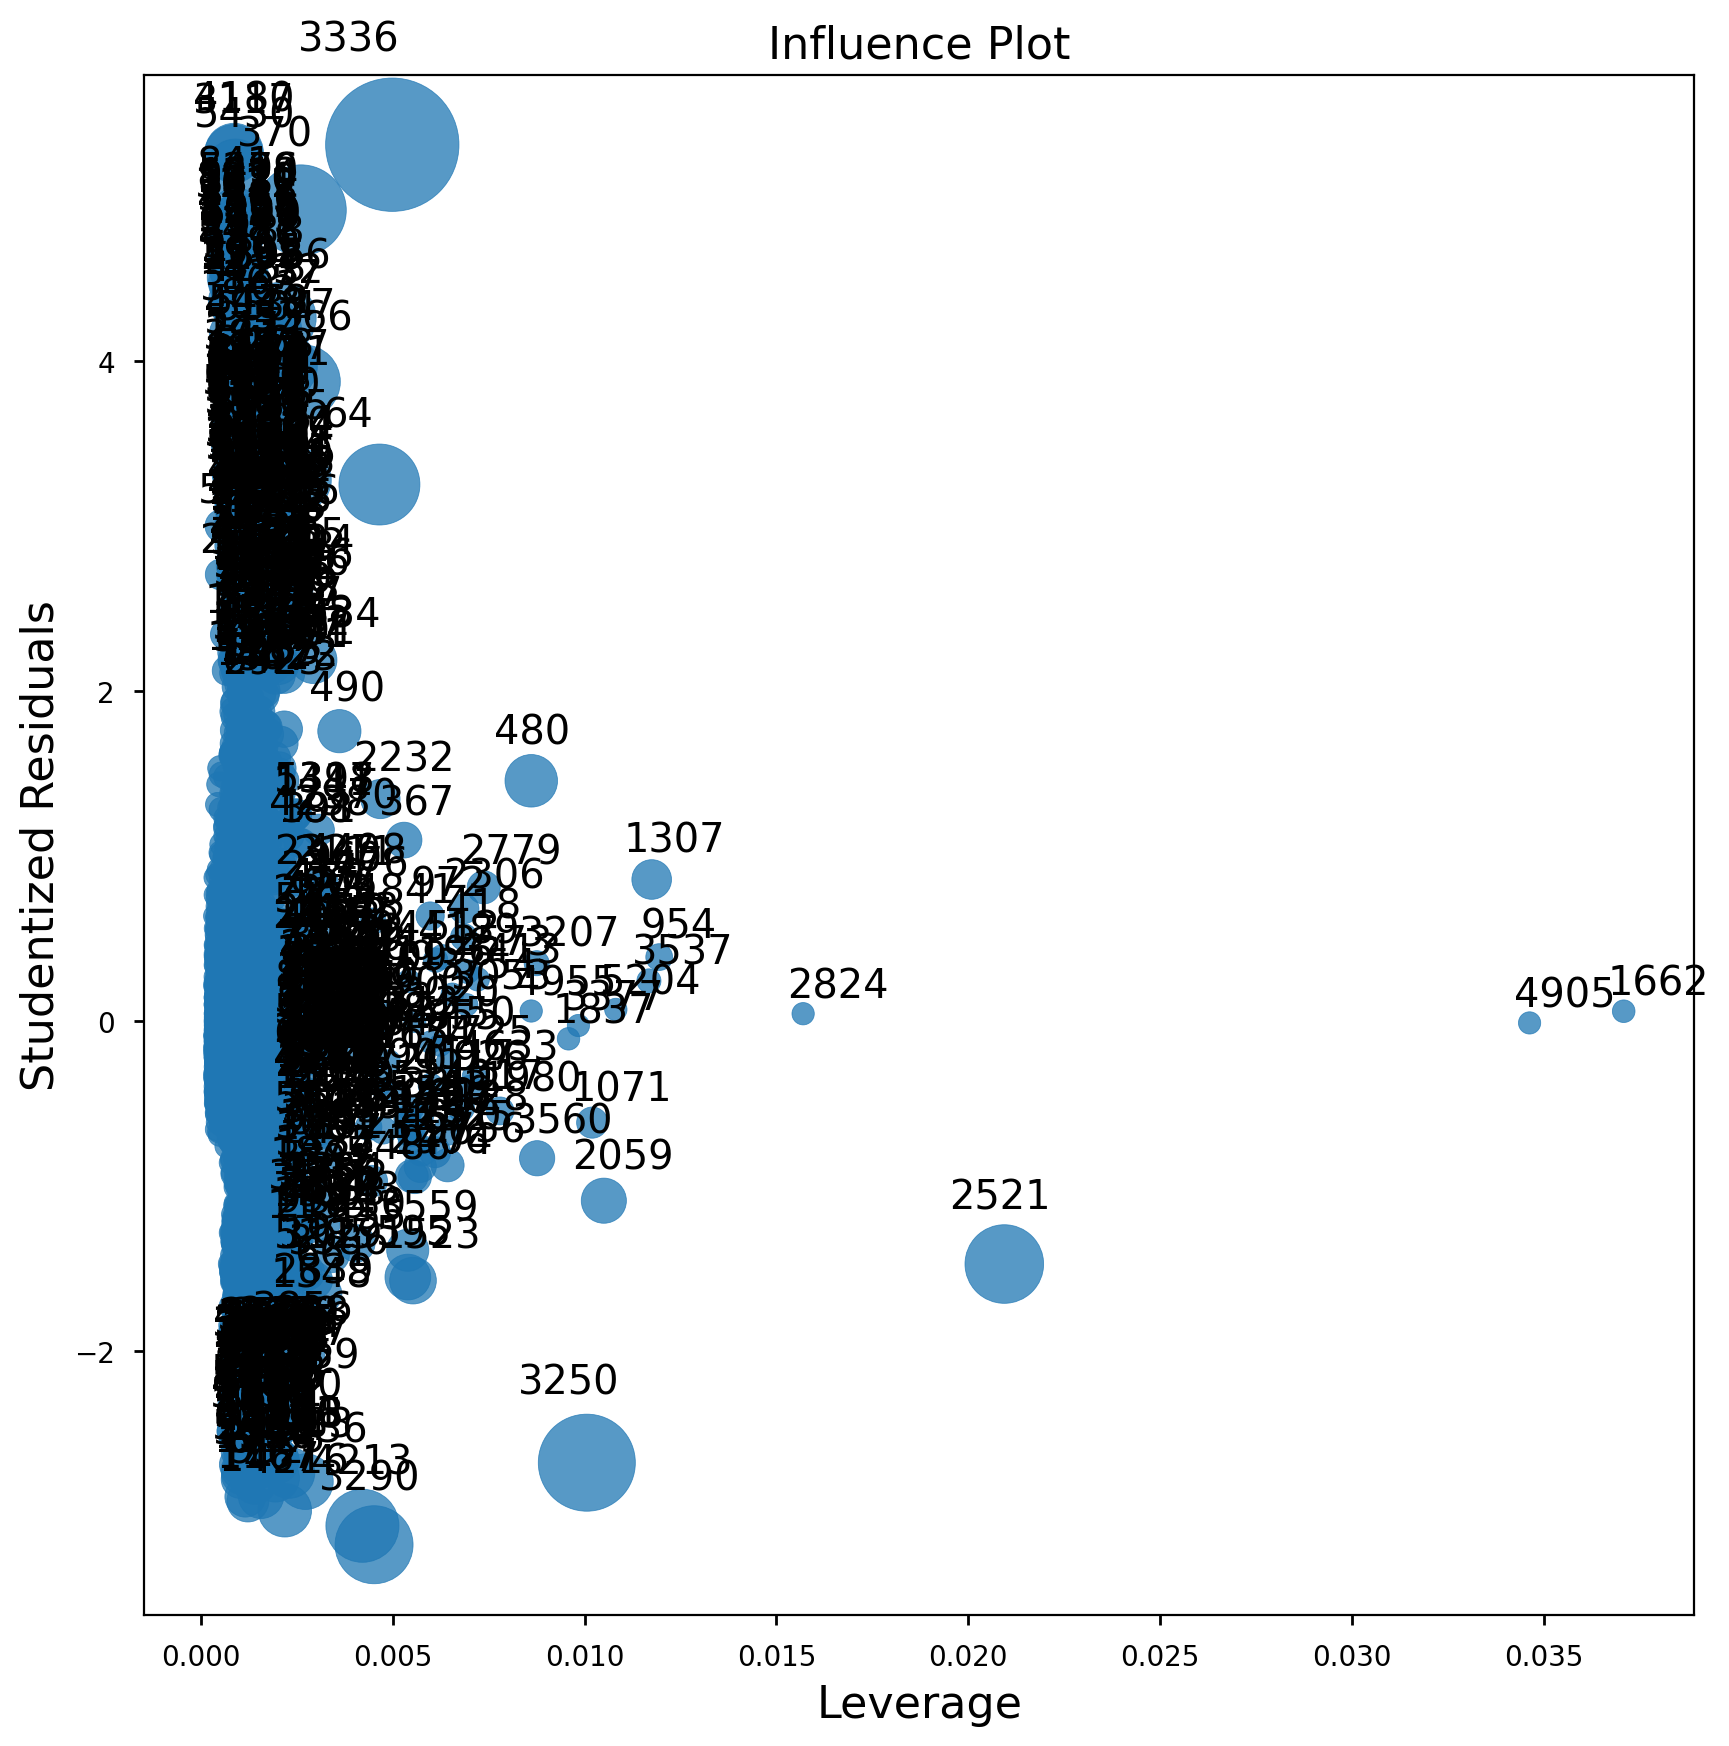

In [268]:
fig, ax = plt.subplots(figsize = (10,10))

fig = sm.graphics.influence_plot(model_small, ax = ax, criterion = 'cooks')

In [269]:
bp_test = het_breuschpagan(model_small.resid, model_small.model.exog)

print(f'test statistic: {bp_test[0]}')
print(f'       p-value: {bp_test[1]}')

test statistic: 1367.80118851374
       p-value: 1.3048218052288884e-293


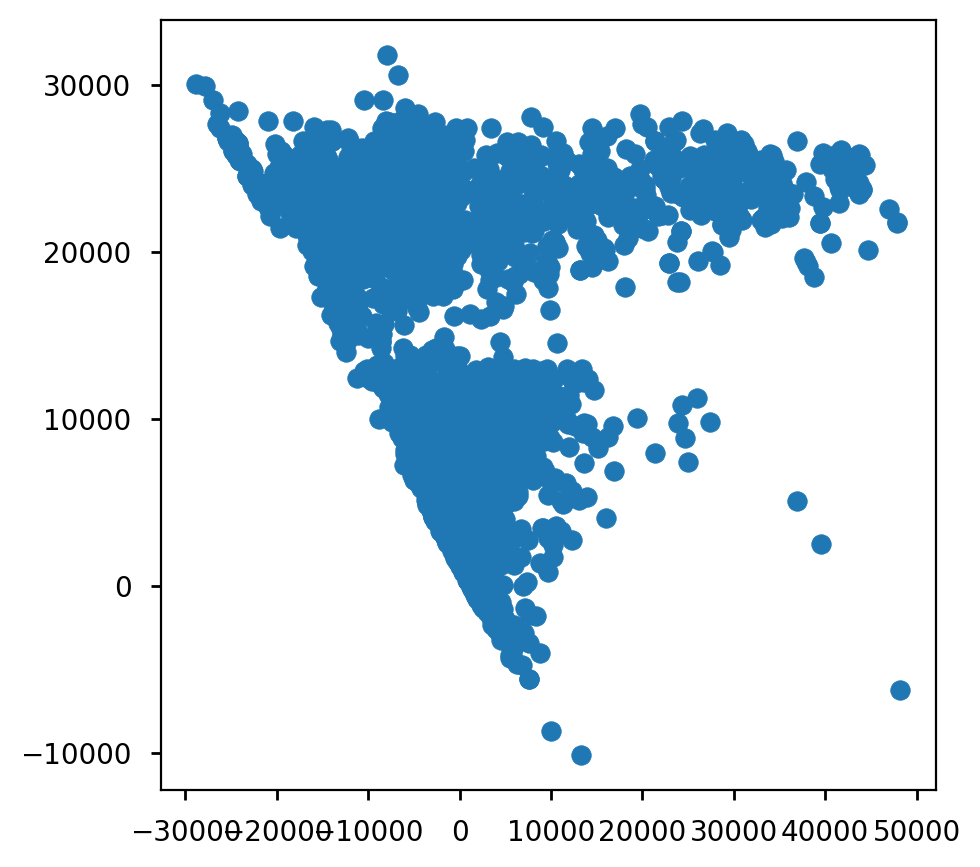

In [270]:
fig, ax = plt.subplots(figsize = (5,5))

ax.scatter(model_small.resid, model_small.fittedvalues)

It looks like we have two distinct groups based off of the fitted-values, both with varying bandwidths. The Breusch-Pagan test also rejects our $H_0$ claim of homoscedasticity, so we should apply a natural-log transformation and re-consider influential points.

# Performing Box-Cox transformation and re-checking influential points

In [271]:
bc = boxcox(cars['price'])

cars['price'] = bc[0]

In [280]:
bc[1]

-0.25859282335321626

Also using WLS regression since we still have heteroscedasticity.

In [285]:
model = smf.glm('price ~ transmission + manufacture + engine + miles + C(new)', 
                 data=cars).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 5512
Model:                            GLM   Df Residuals:                     5506
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                       0.0056156
Method:                          IRLS   Log-Likelihood:                 6464.0
Date:                Sat, 07 Oct 2023   Deviance:                       30.919
Time:                        17:29:50   Pearson chi2:                     30.9
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4599
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -12.6466      0.636    -19.891      0.000     -13.893     -11.400
transmission[T.Manual]    -0.0876      0.002    -36.940      0.000      -0.092      -0.083
C(new)[T.1]                0.0062      0.002      2.615      0.009       0.002       0.011
manufacture                0.0080      0.000     25.446      0.000       0.007       0.009
engine                     0.0084      0.002      4.753      0.000       0.005       0.012
miles                  -5.249e-08   4.47e-08     -1.174      0.240    -1.4e-07    3.51e-08
==========================================================================================
"""

In [286]:
# threshold externally studentized residuals
infl = model.get_influence()
n = len(cars)
p = 5

seuil_stud = stats.t.ppf(0.975,df=n-p-1)

# detection - absolute value > threshold
reg_studs = infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud

df_esr = pd.DataFrame({'externally studentized residuals': reg_studs[atyp_stud],
              'residuals': model.resid[atyp_stud]})

df_esr

AttributeError: 'GLMInfluence' object has no attribute 'resid_studentized_external'

In [274]:
inflsum = infl.summary_frame()
reg_cook = inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n

c_indices = cars.index[atyp_cook]
c_vals = reg_cook[atyp_cook]

df_cook = pd.DataFrame({"Cook's Distances": reg_cook[atyp_cook]})

df_cook.sort_values(by = "Cook's Distances", ascending = False)

,Cook's Distances
3290,0.015549
2353,0.015242
3076,0.014528
1689,0.014491
3394,0.014117
...,...
1548,0.000734
478,0.000733
3182,0.000731
191,0.000729


In [275]:
cars_small = cars.drop(bad, errors = 'ignore')

In [276]:
model = smf.ols('price ~ transmission + manufacture + engine + miles + C(new)', 
                 data=cars_small).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1266.
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:23:10   Log-Likelihood:                 7406.7
No. Observations:                5254   AIC:                        -1.480e+04
Df Residuals:                    5248   BIC:                        -1.476e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -22.4476      0.542    -41.420      0.000     -23.510     -21.385
transmission[T.Manual]    -0.0830      0.002    -43.258      0.000      -0.087      -0.079
C(new)[T.1]                0.0043      0.002      2.268      0.023       0.001       0.008
manufacture                0.0129      0.000     47.907      0.000       0.012       0.013
engine                     0.0089      0.001      6.195      0.000       0.006       0.012
miles                   2.403e-07   3.62e-08      6.646      0.000    1.69e-07    3.11e-07
==============================================================================
Omnibus:                     1154.951   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5076.587
Skew:                          -1.008   Prob(JB):                         0.00
Kurtosis:                       7.374   Cond. No.                     3.15e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

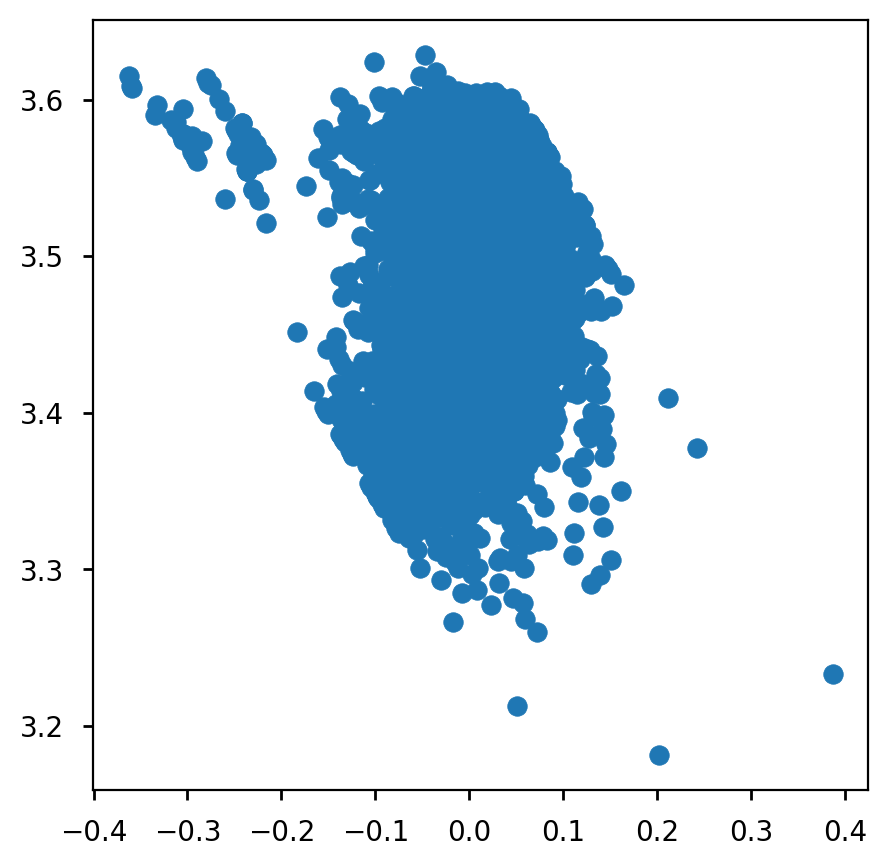

In [277]:
fig, ax = plt.subplots(figsize = (5,5))

ax.scatter(model.resid, model.fittedvalues)

Looks a bit better :)

In [278]:
bp_test = het_breuschpagan(model.resid, model.model.exog)

print(f'test statistic: {bp_test[0]}')
print(f'       p-value: {bp_test[1]}')

test statistic: 292.03030983165115
       p-value: 5.1741429493914266e-61


Still heteroscedasticity present. There are values outside of the main cluster, and since the Breusch-Pagan test is sensitive to those they are likely causing the failure.

SignificanceResult(statistic=5076.586689430255, pvalue=0.0)

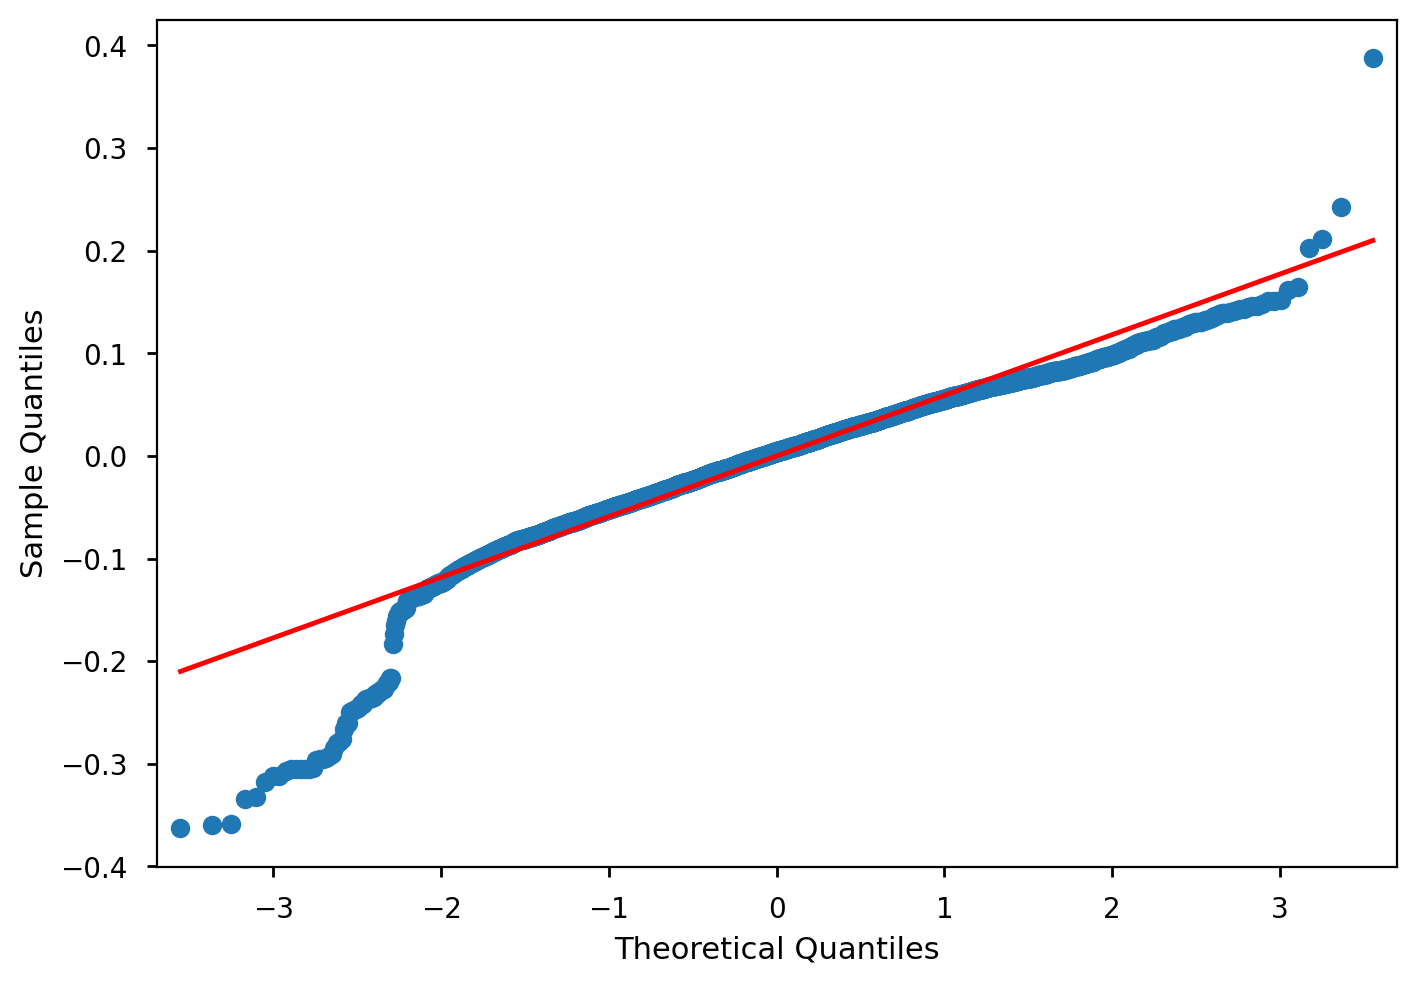

In [279]:
fig = sm.qqplot(model.resid, line = 's')

jb_test = stats.jarque_bera(model.resid)

jb_test